Running notebook will generate annotations files for HOI Transformer using 2.5VRD annotation files. 

Resulting annotations will be written to files:

annotation_train_distances.odgt

annotation_train_occlusions.odgt

annotation_valid_distances.odgt

annotation_valid_occlusions.odgt

annotation_test_distances.odgt

annotation_test_occlusions.odgt

In [1]:
import pandas as pd
import numpy as np
from PIL import Image, ImageDraw, ImageFont
import sys
import json
import time
import os

# Load 2.5VRD Annotation Files

In [2]:
class_descriptions_boxable = pd.read_csv('class-descriptions-boxable.csv', header=None)

within_image_objects_train = pd.read_csv('within_image_objects_train.csv')
within_image_vrd_train = pd.read_csv('within_image_vrd_train.csv')

within_image_objects_validation = pd.read_csv('within_image_objects_validation.csv')
within_image_vrd_validation = pd.read_csv('within_image_vrd_validation.csv')

within_image_objects_test = pd.read_csv('within_image_objects_test.csv')
within_image_vrd_test = pd.read_csv('within_image_vrd_test.csv')

In [3]:
class_descriptions_boxable.iloc[50-1]

0    /m/01bjv
1         Bus
Name: 49, dtype: object

# Define Functions

In [4]:
def progressBar(i, max, text):
    """
    Produce a progress bar during training.
    :param i: index of current iteration/epoch.
    :param max: max number of iterations/epochs.
    :param text: Text to print on the right of the progress bar.
    :return: None
    """
    bar_size = 60
    j = i / max
    
    sys.stdout.write('\r')
    sys.stdout.write(' ' * bar_size * 5)
    sys.stdout.write('\r')
    sys.stdout.write(
        f"[{'=' * int(bar_size * j):{bar_size}s}] {int(100 * j)}%  {text}")
    sys.stdout.flush()
    
def entity_to_name(entity):
    return class_descriptions_boxable[class_descriptions_boxable[0] == entity][1].item()


def name_to_entity(name):
    return class_descriptions_boxable[class_descriptions_boxable[1] == name][0].item()


distance_id_to_name = {
    -1: 'no majority',
    0: 'not sure',
    1: 'A is closer',
    2: 'B is closer',
    3: 'same distance'
}

distance_name_to_id = {
    'no majority': -1,
    'not sure': 0,
    'A is closer': 1,
    'B is closer': 2,
    'same distance': 3
}

occlusion_id_to_name = {
    -1: 'no majority',
    0: 'no occlusion',
    1: 'A occludes B',
    2: 'B occludes A',
    3: 'mutually occluded'
}

occlusion_name_to_id = {
    'no majority': -1,
    'no occlusion': 0,
    'A occludes B': 1,
    'B occludes A': 2,
    'mutually occluded': 3
}

# EDA

## Training Set

In [5]:
within_image_objects_train

,image_id,object_id,entity,xmin,xmax,ymin,ymax
0,000002b66c9c498e,0,/m/01g317,0.151562,0.310937,0.198437,0.590625
1,000002b66c9c498e,1,/m/01g317,0.025000,0.276563,0.714063,0.948438
2,00003d63a4839019,0,/m/07j7r,0.681250,0.999375,0.000000,0.647280
3,00003d63a4839019,1,/m/07j7r,0.000000,0.699375,0.000000,0.668856
4,0000599864fd15b3,0,/m/03bt1vf,0.199375,0.350625,0.444967,0.999059
...,...,...,...,...,...,...,...
211383,fffe519ee3cddd18,1,/m/04yx4,0.223125,0.863125,0.231667,1.000000
211384,fffe53b2f679f98c,0,/m/0dzct,0.349578,0.664480,0.404375,0.710000
211385,fffe53b2f679f98c,1,/m/04yx4,0.025305,0.813496,0.292500,0.988125
211386,ffff1cb23ed29f2a,0,/m/09j2d,0.649375,0.853750,0.618333,0.999167


In [6]:
names = within_image_objects_train['entity'].unique()
count = np.array([0] * len(names))
for i in range(len(count)):
    count[i] = (within_image_objects_train['entity'] == names[i]).sum()

In [7]:
count.min()

1

In [8]:
count.max()

31455

In [9]:
count.mean()

384.34181818181816

In [10]:
count.sort()

In [11]:
import matplotlib.pyplot as plt

In [12]:
within_image_vrd_train

,image_id_1,object_id_1,image_id_2,object_id_2,distance,occlusion,raw_distance,raw_occlusion
0,000002b66c9c498e,0,000002b66c9c498e,1,3,0,3,0
1,00003d63a4839019,0,00003d63a4839019,1,3,3,3,3
2,0000599864fd15b3,0,0000599864fd15b3,1,1,0,1,0
3,000060e3121c7305,0,000060e3121c7305,1,0,0,0,0
4,000096726fd6c6c8,0,000096726fd6c6c8,1,2,2,2,2
...,...,...,...,...,...,...,...,...
105655,fffd4b6d215e5850,0,fffd4b6d215e5850,1,1,0,1,0
105656,fffe28b31f2a70d4,0,fffe28b31f2a70d4,1,0,0,0,0
105657,fffe519ee3cddd18,0,fffe519ee3cddd18,1,0,0,0,0
105658,fffe53b2f679f98c,0,fffe53b2f679f98c,1,0,0,"0,0,0","0,0,0"


### Investigate the number of unique images

In [13]:
print('number of  unique images in within_image_objects_train:    ', within_image_objects_train['image_id'].unique().shape[0])
print('number of  unique images in within_image_vrd_train:        ', within_image_vrd_train['image_id_1'].unique().shape[0])
print('number of  unique images after combining the above two:    ', pd.concat([within_image_objects_train['image_id'], within_image_vrd_train['image_id_1']]).unique().shape[0])

number of  unique images in within_image_objects_train:     105694
number of  unique images in within_image_vrd_train:         105660
number of  unique images after combining the above two:     105694


Since the number of unique images after combining two datasets is the same as the number of images in the within_image_objects_train, within_image_objects_train contains all the images names.

In other words, there are some images that have annotations for objects but no annotation for visual relationships.

We do not want to trian on images which have annotations for objects but no annotation for visual relationships. 

Therefore, we use image names and visual relationships from the vrd annotations, and find their object bounding boxes from the object annotations. 

In [14]:
unique_image_names_train = pd.concat([within_image_objects_train['image_id'], within_image_vrd_train['image_id_1']]).unique()

In [15]:
unique_image_names_train = unique_image_names_train.astype(str)

In [16]:
unique_image_names_train = pd.DataFrame(unique_image_names_train)

In [17]:
unique_image_names_train

,0
0,000002b66c9c498e
1,00003d63a4839019
2,0000599864fd15b3
3,000060e3121c7305
4,000096726fd6c6c8
...,...
105689,fffd4b6d215e5850
105690,fffe28b31f2a70d4
105691,fffe519ee3cddd18
105692,fffe53b2f679f98c


In [18]:
unique_image_names_train.to_csv('unique_image_names_train.csv', index=False)

In [19]:
unique_image_names_train.iloc[16]

0    1386327595826
Name: 16, dtype: object

In [20]:
pwd

'/data/liyang/HoiTransformer/data/2.5vrd'

In [21]:
!'ls | grep unique'

/bin/bash: ls | grep unique: command not found


## Validation Set

In [22]:
within_image_objects_validation

,image_id,object_id,entity,xmin,xmax,ymin,ymax
0,0071f62f5d703904,0,/m/02p5f1q,0.122163,0.345615,0.088189,0.341194
1,0071f62f5d703904,1,/m/02p5f1q,0.167023,0.481887,0.392021,0.773787
2,0071f62f5d703904,2,/m/02p5f1q,0.369314,0.578377,0.123204,0.410093
3,0071f62f5d703904,3,/m/02p5f1q,0.504740,0.854307,0.441718,0.855110
4,0071f62f5d703904,4,/m/02vqfm,0.602288,0.835815,0.455359,0.651093
...,...,...,...,...,...,...,...
4058,ffb9838816c0021a,2,/m/04yx4,0.132984,0.286043,0.110463,0.490701
4059,ffb9838816c0021a,3,/m/083wq,0.569882,0.700175,0.602955,0.946547
4060,ffeba8a4d2029eac,0,/m/04m6gz,0.000000,1.000000,0.256178,0.666241
4061,ffeba8a4d2029eac,1,/m/07j7r,0.000000,1.000000,0.000000,0.602860


In [23]:
within_image_vrd_validation

,image_id_1,object_id_1,image_id_2,object_id_2,distance,occlusion,raw_distance,raw_occlusion
0,0071f62f5d703904,0,0071f62f5d703904,1,2,0,"2,2,2,2,2","0,0,0,0,0"
1,0071f62f5d703904,0,0071f62f5d703904,2,2,0,"2,2,2,2,2","0,0,0,0,0"
2,0071f62f5d703904,0,0071f62f5d703904,3,2,0,"2,2,2,2,2","0,0,0,0,0"
3,0071f62f5d703904,0,0071f62f5d703904,4,2,0,"2,2,2,2,2","0,0,0,0,0"
4,0071f62f5d703904,1,0071f62f5d703904,2,1,0,"1,1,1,2,1","0,0,0,0,0"
...,...,...,...,...,...,...,...,...
6320,ffb9838816c0021a,1,ffb9838816c0021a,2,1,1,"1,1,1,1,1","1,1,1,1,1"
6321,ffb9838816c0021a,2,ffb9838816c0021a,3,2,0,"2,2,2,2,2","0,0,0,0,0"
6322,ffeba8a4d2029eac,0,ffeba8a4d2029eac,1,1,1,"1,1,1,1,1","1,1,1,1,1"
6323,ffeba8a4d2029eac,0,ffeba8a4d2029eac,2,1,1,"1,1,1,1,1","1,1,1,1,0"


### Investigate the number of unique images

In [24]:
print('number of  unique images in within_image_objects_validation:    ', within_image_objects_validation['image_id'].unique().shape[0])
print('number of  unique images in within_image_vrd_validation:        ', within_image_vrd_validation['image_id_1'].unique().shape[0])
print('number of  unique images after combining the above two:         ', pd.concat([within_image_objects_validation['image_id'], within_image_vrd_validation['image_id_1']]).unique().shape[0])

number of  unique images in within_image_objects_validation:     1200
number of  unique images in within_image_vrd_validation:         1196
number of  unique images after combining the above two:          1200


Since the number of unique images after combining two datasets is the same as the number of images in the within_image_objects_validation, within_image_objects_validation contains all the images names.

In other words, there are some images that have annotations for objects but no annotation for visual relationships.

We do not want to validate on images which have annotations for objects but no annotation for visual relationships. 

Therefore, we use image names and visual relationships from the vrd annotations, and find their object bounding boxes from the object annotations. 

## Test Set

In [25]:
within_image_objects_test

,image_id,object_id,entity,xmin,xmax,ymin,ymax
0,0002ab0af02e4a77,0,/m/09j2d,0.407782,0.845727,0.385412,0.999711
1,0002ab0af02e4a77,1,/m/04hgtk,0.534108,0.745821,0.127420,0.462402
2,0003d84e0165d630,0,/m/01g317,0.735415,0.837862,0.014350,0.384812
3,0003d84e0165d630,1,/m/018xm,0.000000,0.198794,0.665719,0.942062
4,000b6e5bfa3e2a34,0,/m/04yx4,0.000000,0.387860,0.174753,0.966402
...,...,...,...,...,...,...,...
13888,ffe04404f471a3e2,5,/m/01_bhs,0.584049,1.000000,0.592052,1.000000
13889,ffe1d00be52c3142,0,/m/07j87,0.036083,0.491698,0.203271,0.787928
13890,ffe1d00be52c3142,1,/m/07j87,0.479360,0.964239,0.300079,0.861355
13891,fffc2ecd02883c6f,0,/m/04hgtk,0.503194,0.828060,0.017568,0.614981


In [26]:
within_image_vrd_test

,image_id_1,object_id_1,image_id_2,object_id_2,distance,occlusion,raw_distance,raw_occlusion
0,0002ab0af02e4a77,0,0002ab0af02e4a77,1,0,0,"0,0,0,0,0","0,0,0,0,0"
1,0003d84e0165d630,0,0003d84e0165d630,1,2,0,"2,2,2,2,2","0,0,0,0,0"
2,000b6e5bfa3e2a34,0,000b6e5bfa3e2a34,1,1,0,"1,0,1,1,1","0,0,1,1,0"
3,000b6e5bfa3e2a34,0,000b6e5bfa3e2a34,2,1,1,"1,1,1,1,1","1,1,1,0,1"
4,000b6e5bfa3e2a34,0,000b6e5bfa3e2a34,3,1,0,"1,1,1,1,1","0,0,0,0,0"
...,...,...,...,...,...,...,...,...
23661,ffe04404f471a3e2,3,ffe04404f471a3e2,4,2,0,"2,2,2,3,2","0,1,0,0,0"
23662,ffe04404f471a3e2,3,ffe04404f471a3e2,5,2,0,"2,2,2,2,2","0,0,0,0,0"
23663,ffe04404f471a3e2,5,ffe04404f471a3e2,4,1,1,"1,1,1,1,1","1,1,1,1,1"
23664,ffe1d00be52c3142,0,ffe1d00be52c3142,1,2,0,"3,2,2,2,3","0,0,0,0,0"


### Investigate the number of unique images

In [27]:
print('number of  unique images in within_image_objects_test:    ', within_image_objects_test['image_id'].unique().shape[0])
print('number of  unique images in within_image_vrd_test:        ', within_image_vrd_test['image_id_1'].unique().shape[0])
print('number of  unique images after combining the above two:   ', pd.concat([within_image_objects_test['image_id'], within_image_vrd_test['image_id_1']]).unique().shape[0])

number of  unique images in within_image_objects_test:     4000
number of  unique images in within_image_vrd_test:         3987
number of  unique images after combining the above two:    4000


Since the number of unique images after combining two datasets is the same as the number of images in the within_image_objects_test, within_image_objects_test contains all the images names.

In other words, there are some images that have annotations for objects but no annotation for visual relationships.

We do not want to test on images which have annotations for objects but no annotation for visual relationships. 

Therefore, we use image names and visual relationships from the vrd annotations, and find their object bounding boxes from the object annotations. 

In [28]:
unique_image_names = within_image_vrd_test['image_id_1'].unique() 

In [29]:
max_relations = -1
num_relations = []
for i in range(len(unique_image_names)):
    current_num_relations = within_image_vrd_test[within_image_vrd_test['image_id_1'] == unique_image_names[i]].shape[0]
    num_relations.append(current_num_relations)
    if current_num_relations > max_relations:
        max_relations = current_num_relations
        
max_relations

227

In [30]:
227 * 2

454

In [31]:
import matplotlib.pyplot as plt

(array([2.557e+03, 1.770e+02, 4.410e+02, 3.080e+02, 1.000e+01, 8.000e+01,
        1.290e+02, 1.800e+01, 8.900e+01, 4.000e+00, 9.000e+00, 6.200e+01,
        1.000e+00, 1.000e+00, 3.000e+00, 2.400e+01, 1.000e+00, 0.000e+00,
        3.000e+00, 2.900e+01, 0.000e+00, 2.000e+00, 2.000e+00, 1.300e+01,
        0.000e+00, 1.000e+00, 3.000e+00, 3.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 3.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

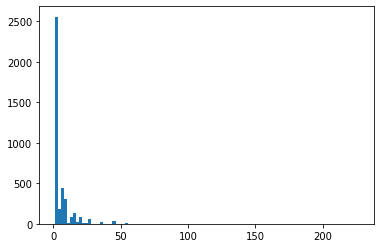

In [32]:
plt.hist(np.array(num_relations), bins = 100)

In [33]:
np.array(num_relations).mean()

5.935791321795836

In [34]:
np.array(num_relations).min()

1

In [35]:
np.array(num_relations).max()

227

In [36]:
(np.array(num_relations) > 50).sum()

39

In [37]:
unique_image_names_obj = within_image_objects_test['image_id'].unique() 

In [38]:
max_objects = -1
num_objects = []
for i in range(len(unique_image_names_obj)):
    current_num_objects = within_image_objects_test[within_image_objects_test['image_id'] == unique_image_names_obj[i]].shape[0]
    num_objects.append(current_num_objects)
    if current_num_objects > max_objects:
        max_objects = current_num_objects
        
max_objects

22

In [39]:
22 * 21 * 2

924

In [40]:
within_image_vrd_train

,image_id_1,object_id_1,image_id_2,object_id_2,distance,occlusion,raw_distance,raw_occlusion
0,000002b66c9c498e,0,000002b66c9c498e,1,3,0,3,0
1,00003d63a4839019,0,00003d63a4839019,1,3,3,3,3
2,0000599864fd15b3,0,0000599864fd15b3,1,1,0,1,0
3,000060e3121c7305,0,000060e3121c7305,1,0,0,0,0
4,000096726fd6c6c8,0,000096726fd6c6c8,1,2,2,2,2
...,...,...,...,...,...,...,...,...
105655,fffd4b6d215e5850,0,fffd4b6d215e5850,1,1,0,1,0
105656,fffe28b31f2a70d4,0,fffe28b31f2a70d4,1,0,0,0,0
105657,fffe519ee3cddd18,0,fffe519ee3cddd18,1,0,0,0,0
105658,fffe53b2f679f98c,0,fffe53b2f679f98c,1,0,0,"0,0,0","0,0,0"


In [41]:
within_image_vrd_train.iloc[105658]['raw_distance']

'0,0,0'

# Define Functions to Build Annotations and Write

In [42]:
# dataset: 'train', 'valid', or 'test'
def build_annotations(dataset):
    
    # Select vrd DataFrame and objects DataFrame
    if dataset == 'train':
        vrd_df = within_image_vrd_train
        object_df = within_image_objects_train
    elif dataset == 'valid':
        vrd_df = within_image_vrd_validation
        object_df = within_image_objects_validation
        dataset = 'validation'
    elif dataset == 'test':
        vrd_df = within_image_vrd_test
        object_df = within_image_objects_test
        
    
    # Find out unique image ids
    unique_image_ids = vrd_df['image_id_1'].unique()

    all_distances = []
    all_occlusions = []

    skipped_images_ids = []
    skipped_indices = []
    num_skipped_images = 0

    num_images = len(unique_image_ids)

    start_time = time.time()
    time_used = 0

    for i in range(num_images):

        # find file name
        image_id = unique_image_ids[i]
        original_image_id = image_id

        # pad zeros to image_id
        num_leading_zeros = 16 - len(image_id)

        for j in range(num_leading_zeros):
            image_id = '0' + image_id


        file_name = image_id + '.jpg'
        path = 'images/' + dataset + '/' + file_name

        try:
            image = Image.open(path)
        except:
            skipped_images_ids.append(original_image_id)
            skipped_indices.append(i)
            num_skipped_images += 1
            continue

        # find width and height
        width = image.width
        height = image.height

        # find bounding boxes from object_df
        df = object_df[object_df['image_id'] == image_id]

        # Box_array in odgt annotaions should be in xywh format
        box_array = [None] * df.shape[0]
        tag_array = [None] * df.shape[0]

        for j in range(df.shape[0]):
            object_id = df.iloc[j]['object_id']
            xmin = df.iloc[j]['xmin'] * width
            ymin = df.iloc[j]['ymin'] * height
            xmax = df.iloc[j]['xmax'] * width
            ymax = df.iloc[j]['ymax'] * height

            entity = df.iloc[j]['entity']
            tag = entity_to_name(entity)

            box_array[j] = [xmin, ymin, xmax - xmin, ymax - ymin]
            tag_array[j] = tag

        # Find occlusion and distance relationships from vrd_df
        df = vrd_df[vrd_df['image_id_1'] == image_id]

        pair_array = [None] * (df.shape[0])
        distance_array = [None] * (df.shape[0])
        occlusion_array = [None] * (df.shape[0])

        for j in range(df.shape[0]):
            object_id_1 = df.iloc[j]['object_id_1']
            object_id_2 = df.iloc[j]['object_id_2']
            distance = df.iloc[j]['distance']
            occlusion = df.iloc[j]['occlusion']
            
            # TODO

            pair_array[j] = [object_id_1, object_id_2]
            distance_array[j] = distance
            occlusion_array[j] = occlusion
            raw_distance_array[j] = raw_distance
            raw_occlusion_array[j] = raw_occlusion
            

        # Build distance and occlusion
        distance = []
        occlusion = []
        gtboxes = []

        # Boxes 
        for j in range(len(box_array)):
            gtboxes.append(dict(box=box_array[j], tag=tag_array[j]))

        # Distances and Occlusions
        for j in range(len(pair_array)):        
            subject_id = pair_array[j][0]
            object_id = pair_array[j][1]

            # distance
            category_id = distance_array[j]
            interaction = distance_id_to_name[category_id]

            dist_pp = dict(subject_id=str(subject_id),
                           object_id=str(object_id),
                           category_id=str(category_id), 
                           interaction=interaction
                           )
            distance.append(dist_pp)



            # occlusion
            category_id = occlusion_array[j]
            interaction = occlusion_id_to_name[category_id]

            occl_pp = dict(subject_id=str(subject_id),
                           object_id=str(object_id),
                           category_id=str(category_id), 
                           interaction=interaction
                           )
            occlusion.append(occl_pp)



        all_distances.append(dict(file_name=file_name, width=width, height=height, gtboxes=gtboxes, hoi=distance, ID=''))
        all_occlusions.append(dict(file_name=file_name, width=width, height=height, gtboxes=gtboxes, hoi=occlusion, ID=''))


        if (i + 1) % 10 == 0 or i + 1== num_images:
            fixed_status_string = 'Generating Annotations'
            dynamic_status_string = str(i + 1) + '/' + str(num_images)

            time_used = time.time() - start_time
            speed = (i + 1) / time_used
            time_remaining = (num_images - (i + 1)) / speed
            remaining_hours = time_remaining / 3600
            remaining_minutes = (time_remaining % 3600) / 60
            remaining_seconds = time_remaining % 60
            time_string = str(int(remaining_hours)) + ' h ' + str(int(remaining_minutes)) +' min ' + str(int(remaining_seconds)) + ' s'


            progressBar(i + 1, num_images, '  ' + fixed_status_string + '  ' + dynamic_status_string + '  ' + '|  Skipped Images: ' + str(num_skipped_images) + '  |  ' + 'Time Remining: ' + time_string)
            
    return all_distances, all_occlusions, skipped_images_ids, skipped_indices, num_skipped_images

In [43]:
# file_name: file name of distance annotation file
def write_distances(file_name, all_distances):
    
    os.system('rm -f %s' % file_name)

    with open(file_name, 'a') as writer:
    
        for i in range(len(all_distances)):
            item = all_distances[i]
            writer.write(json.dumps(item) + "\n")
            if i % 100 == 0 or i == len(all_distances) - 1:
                progressBar(i + 1, len(all_distances), 'Writing Annotations to File:    ' + file_name)

In [44]:
# file_name: file name of occlusion annotation file
def write_occlusions(file_name, all_occlusions):
    
    os.system('rm -f %s' % file_name)

    with open(file_name, 'a') as writer:
        for i in range(len(all_occlusions)):
            item = all_occlusions[i]
            writer.write(json.dumps(item) + "\n")
            if i % 100 == 0 or i == len(all_occlusions) - 1:
                progressBar(i + 1, len(all_occlusions), 'Writing Annotations to File:    ' + file_name)

In [45]:
# dataset: 'train', 'valid', or 'test'
def build_and_write_annotations(dataset):
    all_distances, all_occlusions, skipped_images_ids, skipped_indices, num_skipped_images = build_annotations(dataset)
    
    file_name_diatances = 'annotation_' + dataset + '_distances' + '.odgt'
    file_name_occlusions = 'annotation_' + dataset + '_occlusions' + '.odgt'
    
    print()
    write_distances(file_name_diatances, all_distances)
    
    print()
    write_occlusions(file_name_occlusions, all_occlusions)

# Build and Write Annotations

## Training Set

In [46]:
#build_and_write_annotations('train')

## Validation Set

In [47]:
#build_and_write_annotations('valid')

## Test Set

In [48]:
#build_and_write_annotations('test')

# Check Resulting Annotations Files

In [49]:
#!wc -l annotation_train_distances.odgt

In [50]:
#!wc -l annotation_train_occlusions.odgt

In [51]:
#!wc - l annotation_valid_distances.odgt

In [52]:
#!wc -l annotation_valid_occlusions.odgt

In [53]:
#!wc -l annotation_test_distances.odgt

In [54]:
#!wc -l annotation_test_occlusions.odgt

In [55]:
def flip_distance(original_distance):
    if original_distance in [-1, 0, 3]:
        return original_distance
    elif original_distance in [1]:
        return 2
    elif original_distance in [2]:
        return 1
    else: 
        return -99

In [56]:
def flip_occlusion(original_occlusion):
    if original_occlusion in [-1, 0, 3]:
        return original_occlusion
    elif original_occlusion in [1]:
        return 2
    elif original_occlusion in [2]:
        return 1
    else:
        return -99

In [67]:
# dataset: 'train', 'valid', or 'test'
def build_combined_annotations(dataset):
    
    # Select vrd DataFrame and objects DataFrame
    if dataset == 'train':
        vrd_df = within_image_vrd_train
        object_df = within_image_objects_train
    elif dataset == 'valid':
        vrd_df = within_image_vrd_validation
        object_df = within_image_objects_validation
        dataset = 'validation'
    elif dataset == 'test':
        vrd_df = within_image_vrd_test
        object_df = within_image_objects_test
        
    
    # Find out unique image ids
    unique_image_ids = vrd_df['image_id_1'].unique()

    all_distances = []
    all_occlusions = []
    
    all_combined = []

    skipped_images_ids = []
    skipped_indices = []
    num_skipped_images = 0

    num_images = len(unique_image_ids)

    start_time = time.time()
    time_used = 0

    for i in range(num_images):

        # find file name
        image_id = unique_image_ids[i]
        original_image_id = image_id

        # pad zeros to image_id
        num_leading_zeros = 16 - len(image_id)

        for j in range(num_leading_zeros):
            image_id = '0' + image_id


        file_name = image_id + '.jpg'
        path = 'images/' + dataset + '/' + file_name

        try:
            image = Image.open(path)
        except:
            skipped_images_ids.append(original_image_id)
            skipped_indices.append(i)
            num_skipped_images += 1
            continue

        # find width and height
        width = image.width
        height = image.height

        # find bounding boxes from object_df
        df = object_df[object_df['image_id'] == image_id]

        # Box_array in odgt annotaions should be in xywh format
        box_array = [None] * df.shape[0]
        tag_array = [None] * df.shape[0]

        for j in range(df.shape[0]):
            object_id = df.iloc[j]['object_id']
            xmin = df.iloc[j]['xmin'] * width
            ymin = df.iloc[j]['ymin'] * height
            xmax = df.iloc[j]['xmax'] * width
            ymax = df.iloc[j]['ymax'] * height

            entity = df.iloc[j]['entity']
            tag = entity_to_name(entity)

            box_array[j] = [xmin, ymin, xmax - xmin, ymax - ymin]
            tag_array[j] = tag

        # Find occlusion and distance relationships from vrd_df
        df = vrd_df[vrd_df['image_id_1'] == image_id]

        pair_array = [None] * (df.shape[0])
        distance_array = [None] * (df.shape[0])
        occlusion_array = [None] * (df.shape[0])
        raw_distance_array = [None] * (df.shape[0])
        raw_occlusion_array = [None] * (df.shape[0])

        for j in range(df.shape[0]):
            object_id_1 = df.iloc[j]['object_id_1']
            object_id_2 = df.iloc[j]['object_id_2']
            distance = df.iloc[j]['distance']
            occlusion = df.iloc[j]['occlusion']
            raw_distance = df.iloc[j]['raw_distance']
            raw_occlusion = df.iloc[j]['raw_occlusion']

            pair_array[j] = [object_id_1, object_id_2]
            distance_array[j] = distance
            occlusion_array[j] = occlusion
            raw_distance_array[j] = raw_distance
            raw_occlusion_array[j] = raw_occlusion

        # Build distance and occlusion
        distance = []
        occlusion = []
        gtboxes = []
        combined = []

        # Boxes 
        for j in range(len(box_array)):
            gtboxes.append(dict(box=box_array[j], tag=tag_array[j]))

        # Distances and Occlusions
        for j in range(len(pair_array)):        
            subject_id = pair_array[j][0]
            object_id = pair_array[j][1]

            # distance
            distance_id = distance_array[j]
            distance = distance_id_to_name[distance_id]

            # occlusion
            occlusion_id = occlusion_array[j]
            occlusion = occlusion_id_to_name[occlusion_id]
            
            # raw distance
            raw_distance = raw_distance_array[j]
            
            # raw occlusion
            raw_occlusion = raw_occlusion_array[j]
            
            
            combined_pp = dict(subject_id=str(subject_id),
                           object_id=str(object_id),
                           distance_id=str(distance_id), 
                           distance=distance, 
                           occlusion_id=str(occlusion_id),
                           occlusion=occlusion, 
                           raw_distance=str(raw_distance), 
                           raw_occlusion=str(raw_occlusion))
            
            combined.append(combined_pp)
            
            
            # Add a flipped pp
            flipped_subject_id = object_id
            flipped_object_id = subject_id
            flipped_distance_id = flip_distance(distance_id)
            flipped_distance = distance_id_to_name[flipped_distance_id]
            flipped_occlusion_id = flip_occlusion(occlusion_id)
            flipped_occlusion = occlusion_id_to_name[flipped_occlusion_id]
            
            # TODO: flip raw distance and raw occlusion
            flipped_raw_distance = ''
            flipped_raw_occlusion = ''
            
            num_raw_distance = int(len(raw_distance) / 2) + 1
            num_raw_occlusion = int(len(raw_occlusion) / 2) + 1
             
            for k in range(num_raw_distance):
                current_raw_distance = int(raw_distance[k*2: k*2+1])
                current_flipped_raw_distance = flip_distance(current_raw_distance)
                flipped_raw_distance += str(current_flipped_raw_distance)
                if k < num_raw_distance - 1:
                    flipped_raw_distance += ','
            
            for k in range(num_raw_occlusion):
                current_raw_occlusion = int(raw_occlusion[k*2: k*2+1])
                current_flipped_raw_occlusion = flip_occlusion(current_raw_occlusion)
                flipped_raw_occlusion += str(current_flipped_raw_occlusion)
                if k < num_raw_distance - 1:
                    flipped_raw_occlusion += ','
            
            
            flipped_pp = dict(subject_id=str(flipped_subject_id),
                           object_id=str(flipped_object_id),
                           distance_id=str(flipped_distance_id), 
                           distance=flipped_distance, 
                           occlusion_id=str(flipped_occlusion_id),
                           occlusion=flipped_occlusion, 
                           raw_distance=flipped_raw_distance, 
                           raw_occlusion=flipped_raw_occlusion)
            combined.append(flipped_pp)
            
            
        all_combined.append(dict(file_name=file_name, width=width, height=height, gtboxes=gtboxes, hoi=combined, ID=''))
        
        
        if (i + 1) % 10 == 0 or i + 1== num_images:
            fixed_status_string = 'Generating Annotations'
            dynamic_status_string = str(i + 1) + '/' + str(num_images)

            time_used = time.time() - start_time
            speed = (i + 1) / time_used
            time_remaining = (num_images - (i + 1)) / speed
            remaining_hours = time_remaining / 3600
            remaining_minutes = (time_remaining % 3600) / 60
            remaining_seconds = time_remaining % 60
            time_string = str(int(remaining_hours)) + ' h ' + str(int(remaining_minutes)) +' min ' + str(int(remaining_seconds)) + ' s'

            progressBar(i + 1, num_images, '  ' + fixed_status_string + '  ' + dynamic_status_string + '  ' + '|  Skipped Images: ' + str(num_skipped_images) + '  |  ' + 'Time Remining: ' + time_string)
            
    return all_combined, skipped_images_ids, skipped_indices, num_skipped_images

  

def write_combined(file_name, all_combined):
    os.system('rm -f %s' % file_name)

    with open(file_name, 'a') as writer:
    
        for i in range(len(all_combined)):
            item = all_combined[i]
            writer.write(json.dumps(item) + "\n")
            if i % 100 == 0 or i == len(all_combined) - 1:
                progressBar(i + 1, len(all_combined), 'Writing Annotations to File:    ' + file_name)

def build_and_write_combined_annotations(dataset):
    all_combined, skipped_images_ids, skipped_indices, num_skipped_images = build_combined_annotations(dataset)
    
    file_name_combined = 'annotation_' + dataset + '_combined' + '.odgt'
    
    print()
    write_combined(file_name_combined, all_combined)

In [68]:
build_and_write_combined_annotations('valid')

[============================================================] 100%    Generating Annotations  1196/1196  |  Skipped Images: 0  |  Time Remining: 0 h 0 min 0 s                                                                                                                                             
[============================================================] 100%  Writing Annotations to File:    annotation_valid_combined.odgt                                                                                                                                                                         

In [69]:
build_and_write_combined_annotations('test')

[============================================================] 100%    Generating Annotations  3987/3987  |  Skipped Images: 2  |  Time Remining: 0 h 0 min 0 s                                                                                                                                             
[============================================================] 100%  Writing Annotations to File:    annotation_test_combined.odgt                                                                                                                                                                          

In [70]:
build_and_write_combined_annotations('train')

[============================================================] 100%    Generating Annotations  105660/105660  |  Skipped Images: 20  |  Time Remining: 0 h 0 min 0 s                                                                                                                                        
[============================================================] 100%  Writing Annotations to File:    annotation_train_combined.odgt                                                                                                                                                                         